In [44]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from icecream import ic

M, T, a, b = 10000, 1, 2, 0.1

def monte_carlo(a, b, T, dt, s0, paths):
    steps = int(T/dt)
    Z = np.random.normal(0.0, 1.0, [paths, steps])
    X = np.zeros([paths, steps])
    X[:,0] = s0

    for i in range(steps-1):
        X[:, i + 1] =  X[:, i] + (a * X[:, i]) * dt + b * X[:,i]  * np.power(dt, 0.5) * Z[:, i]
    return X


def expectation(t,s0, a):
    return s0*np.exp(a*t)


def slope(X, T):
    slope, _ = np.polyfit(T, X, 1)
    return slope

In [14]:
def monte_carlo2(a, b, T, dt, s0, paths):
    M = paths
    N = int(T/dt)
    #Create Large Matrix for Forward Euler
    randM = np.random.normal(0, b*np.sqrt(dt), size=(M,N))
    A = randM + (1+a*dt)*np.ones((M,N))
    
    #Calculate samples of X_N by taking the product over N elements
    Prod = np.prod(A, axis = 1)
    
    #Some variance reduction (To minimise statistical error)
    LogN = np.exp((a - 0.5*b**2)*np.ones(M) + np.sum(randM, axis = 1))
    
    #Estimate optimal beta
    Cov = np.cov([Prod, LogN])
    var = (np.exp(b**2) - 1)*np.exp(2*a)
    beta = Cov[0,1]/var
    
    #Monte Carlo Average Using Variance Reduction
    return Prod- beta*LogN + beta*np.exp(a)

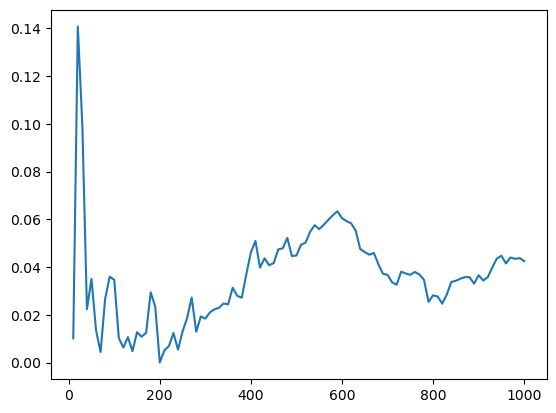

In [15]:
def convergence_rate_M(): 
    res = []  
    m_space =np.linspace(10, 1000, 100)
    X = monte_carlo(a, b, T, T/1000, 1, 10000)
    for m in m_space:
        EX = np.mean(X[:int(m),:], axis=0)[-1]
        res.append(np.abs(EX - expectation(T, 1, a)))
    plt.plot(m_space, res)

convergence_rate_M()

(10, 1000)

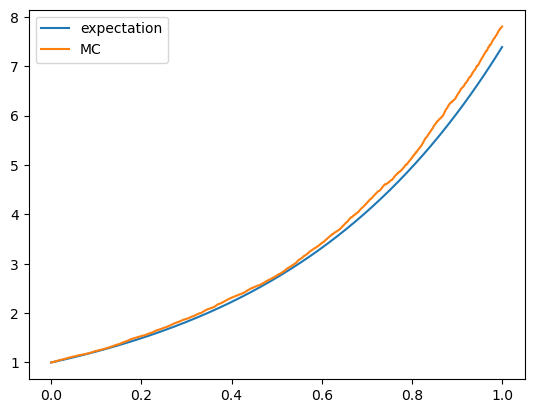

In [16]:
x = np.linspace(0, 1, 1000)
X = monte_carlo(a, b, T, T/1000, 1, 10)
plt.plot(x, expectation(x, 1, a), label="expectation")
plt.plot(x, np.mean(X, axis=0), label="MC")
plt.legend()
X.shape

100%|██████████| 30/30 [00:26<00:00,  1.15it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


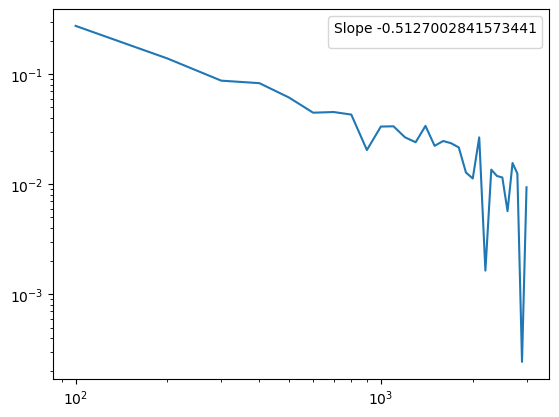

In [17]:
def convergence_rate_N(): 
    res = []  
    n_space = np.linspace(100, 3000, 30)
    for n in tqdm(n_space):
        X = monte_carlo(a, b, T, T/int(n), 1, 10000)
        EX = np.mean(X, axis=0)[-1]
        res.append(np.abs(EX - expectation(T, 1, a)))
    plt.yscale('log')
    plt.xscale('log')
    plt.plot(n_space, res)
    plt.legend(title = f"Slope {slope(np.log(n_space), np.log(res))}")

convergence_rate_N()

100%|██████████| 30/30 [00:14<00:00,  2.03it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


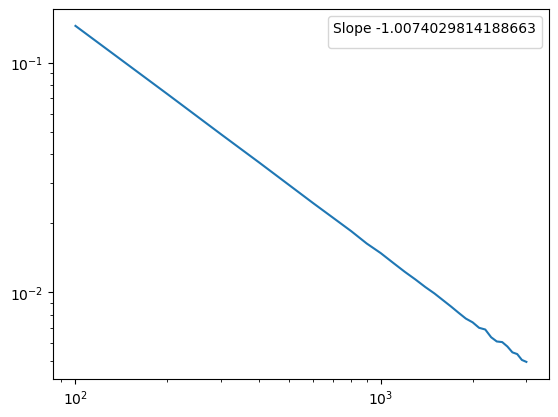

In [ ]:
def convergence_rate_N_p(): 
    res = []  
    n_space = np.linspace(100, 3000, 30)
    for n in tqdm(n_space):
        X = monte_carlop(a, b, T, T/int(n), 1, 10000)
        EX = np.mean(X)
        res.append(np.abs(EX - expectation(T, 1, a)))
    plt.yscale('log')
    plt.xscale('log')
    plt.plot(n_space, res)
    plt.legend(title = f"Slope {slope(np.log(n_space), np.log(res))}")

convergence_rate_N_p()

# 2

In [78]:
def convergence_rate_N_richardson(): 
    res = []  
    n_space = np.linspace(100, 3000, 30)
    for n in n_space:
        X  = monte_carlo(a, b, T, T/int(n), 1, 10000)
        X2 = monte_carlo(a, b, T, T/int(2*n), 1, 10000)
        EX = np.abs(np.mean(X[:,-1]-X2[:,-1]))
        res.append(EX)
    plt.yscale('log')
    plt.xscale('log')
    plt.plot(n_space, res)


def convergence_rate_N_richardson2(): 
    res = []  
    real_err = []
    n_space = np.linspace(100, 3000, 30)
    for n in n_space:
        X = monte_carlo2(a, b, T, T/int(n), 1, 10000)
        X2 = monte_carlo2(a, b, T, T/int(2*n), 1, 10000)
        EX = np.abs(np.mean(X-X2))
        real_err.append(np.abs(np.mean(X) - expectation(T, 1, a)))
        res.append(EX)
    return n_space, res, real_err


n_space, res, real_err = convergence_rate_N_richardson2()


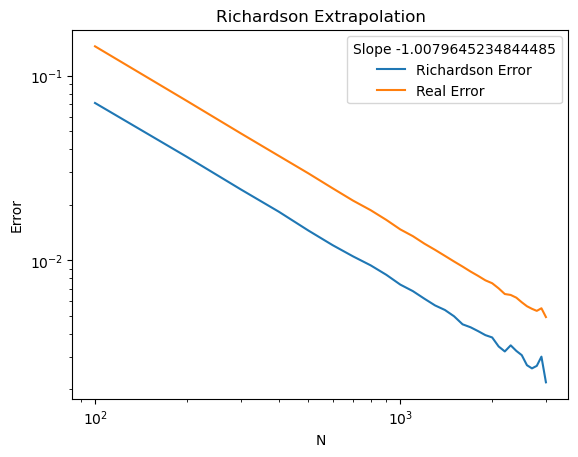

In [80]:
plt.yscale('log')
plt.xscale('log')
plt.plot(n_space, res, label="Richardson Error")
plt.plot(n_space, real_err, label="Real Error")
plt.legend(title = f"Slope {slope(np.log(n_space), np.log(res))}")
plt.title("Richardson Extrapolation")
# plt.grid()
plt.xlabel("N")
plt.ylabel("Error")
plt.savefig("plots/richardson.png", dpi=300)

# 3

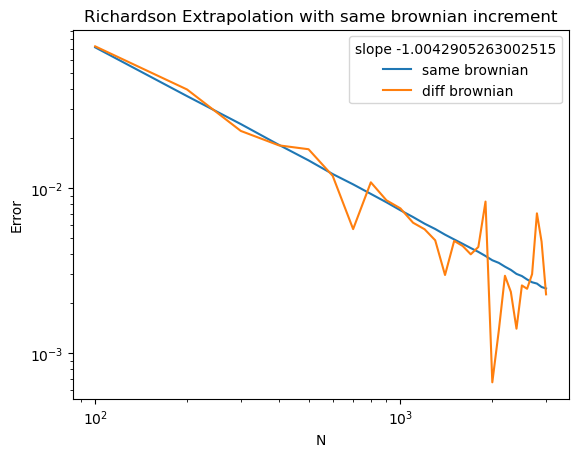

In [82]:
def monte_carlo_richardson(a, b, T, dt, s0, paths):
    steps = int(T/dt)
    Z = np.random.normal(0.0, 1.0, [paths, 2*steps])

    X = np.zeros([paths, steps])
    X2 = np.zeros([paths, 2*steps])
    X[:,0] = s0

    for i in range(steps-1):
        ii = 2*i
        dZ = Z[:, ii + 1] + Z[:, ii]
        X[:, i + 1] =  X[:, i] + (a * X[:, i]) * dt + b * X[:,i]  * np.power(dt, 0.5) * dZ

        X2[:, ii + 1] =  X2[:, ii] + (a * X2[:, ii]) * dt + b * X2[:,ii]  * np.power(dt, 0.5) * Z[:, ii]
        ii += 1
        X2[:, ii + 1] =  X2[:, ii] + (a * X2[:, ii]) * dt + b * X2[:,ii]  * np.power(dt, 0.5) * Z[:, ii]
    return X, X2


def monte_carlo2_richardson(a, b, T, dt, s0, paths):
    def compute(N, randM, dt):
        #Create Large Matrix for Forward Euler
        M = paths
        A = randM + (1+a*dt)*np.ones((M,N))
        
        #Calculate samples of X_N by taking the product over N elements
        Prod = np.prod(A, axis = 1)
        #Some variance reduction (To minimise statistical error)
        LogN = np.exp((a - 0.5*b**2)*np.ones(M) + np.sum(randM, axis = 1))
        
        #Estimate optimal beta
        Cov = np.cov([Prod, LogN])
        var = (np.exp(b**2) - 1)*np.exp(2*a)
        beta = Cov[0,1]/var
    
        #Monte Carlo Average Using Variance Reduction
        return Prod- beta*LogN + beta*np.exp(a)
    
    N = int(T/dt)
    M = paths
    randM = np.random.normal(0, b*np.sqrt(dt/2), size=(M,2*N))
    
    X2 = compute(2*N, randM,dt/2)
    randM = randM[:, ::2] + randM[:, 1::2]
    X = compute(N, randM, dt)
    return X, X2

def convergence_rate_N_richardson():
    samebw = []  
    diffbw = []  
    n_space = np.linspace(100, 10000, 30)
    for n in n_space:
        X, X2 = monte_carlo_richardson(a, b, T, T/int(n), 1, 1000)
        X22 = monte_carlo(a, b, T, T/int(n*2), 1, 1000)
        EX = np.mean(X[:,-1]-X2[:,-1])
        samebw.append(EX)
        diffbw.append(np.mean(X[:,-1]-X22[:,-1]))
    
    plt.plot(n_space, samebw)
    plt.plot(n_space, diffbw)

def convergence_rate_N_richardson2():
    samebw = []  
    diffbw = []  
    n_space = np.linspace(100, 3000, 30)
    for n in n_space:
        X, X2 = monte_carlo2_richardson(a, b, T, T/int(n), 1, 1000)
        X22 = monte_carlo2(a, b, T, T/int(n*2), 1, 1000)
        EX = np.abs(np.mean(X-X2))
        samebw.append(EX)
        diffbw.append(np.abs(np.mean(X-X22)))
    
    plt.plot(n_space, samebw, label="same brownian")
    plt.plot(n_space, diffbw, label="diff brownian")
    
    plt.legend(title=f'slope {slope(np.log(n_space), np.log(samebw))}')
    plt.yscale('log')
    plt.title("Richardson Extrapolation with same brownian increment")
    plt.xlabel("N")
    plt.ylabel("Error")
    plt.xscale('log')
    plt.savefig("plots/richardson2.png", dpi=300)

convergence_rate_N_richardson2()

# 4

100%|██████████| 30/30 [10:21<00:00, 20.73s/it]


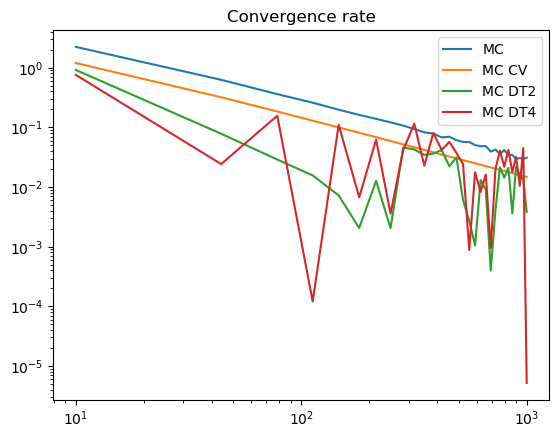

In [ ]:
def monte_carlo(a, b, T, dt, s0, paths):
    steps = int(T/dt)
    Z = np.random.normal(0.0, 1.0, [paths, steps])
    X = np.zeros([paths, steps])
    X[:,0] = s0

    for i in range(steps-1):
        X[:, i + 1] =  X[:, i] + (a * X[:, i]) * dt + b * X[:,i]  * np.power(dt, 0.5) * Z[:, i]
    return X

def monte_carlo_y(a,b,T,dt,s0,paths):
    X_t = monte_carlo(a, b, T, dt, s0, paths)
    X_2t = monte_carlo(a, b, T, 2*dt, s0, paths)
    Y = 2*X_t[:,-1] - X_2t[:,-1]
    return Y
 

def efficient_m2(a,b,T,dt,s0, paths):
    Y_t = monte_carlo_y(a,b,T,dt,s0,paths)
    return Y_t
    # Y_2t = monte_carlo_y(a,b,T,2*dt,s0,paths)    
    
    # Y_4t = monte_carlo_y(a,b,T,4*dt,s0,paths)
    
    # X = 32* Y_t - 12*Y_2t + Y_4t
    # return 1/32 *np.mean(X)

def efficient_m4(a,b,T,dt,s0, paths):
    Y_t = monte_carlo_y(a,b,T,dt,s0,paths)
    Y_2t = monte_carlo_y(a,b,T,2*dt,s0,paths)    
    
    Y_4t = monte_carlo_y(a,b,T,4*dt,s0,paths)
    
    X = 32* Y_t - 12*Y_2t + Y_4t
    return 1/21* X 

def monte_carlo_e(*args, **kwargs):
    X = monte_carlo(*args, **kwargs)
    EX = np.mean(X, axis=0)[-1]
    return EX

# N = 1000
# M = 10000



mc = [] 
mc_cv = [] 
mc_dt2 = []
mc_dt4 = []
n_space = np.linspace(10, 1000, 30)
for n in tqdm(n_space):
    for f, l in list(zip([monte_carlo_e, monte_carlo2, efficient_m2, efficient_m4], [mc, mc_cv, mc_dt2, mc_dt4]))[0:4]:
        X = f(a, b, T, T/int(n), 1, 100000)
        l.append(np.abs(np.mean(X) - expectation(T, 1, a)))
plt.yscale('log')
plt.xscale('log')
plt.plot(n_space, mc, label="MC")
plt.plot(n_space, mc_cv, label="MC CV")
plt.plot(n_space, mc_dt2, label="MC DT2")
plt.plot(n_space, mc_dt4, label="MC DT4")
plt.legend()
plt.xlabel("N")
plt.ylabel("Error")
# plt.grid()
plt.title("Convergence rate")
plt.savefig("plots/convergence_rate.png", dpi=300)

-0.5445243895388989
-0.6100899396247657
-1.1315294510496672
-1.1003834814968727


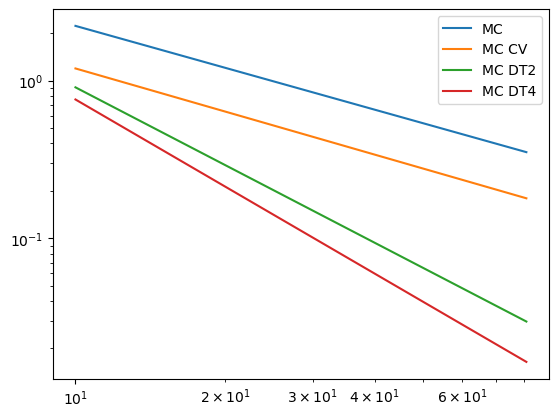

In [68]:
p=6
plt.plot(n_space[:len(n_space)//p], mc[:len(n_space)//p], label="MC")
plt.plot(n_space[:len(n_space)//p], mc_cv[:len(n_space)//p], label="MC CV")
plt.plot(n_space[:len(n_space)//p], mc_dt2[:len(n_space)//p], label="MC DT2")
plt.plot(n_space[:len(n_space)//p], mc_dt4[:len(n_space)//p], label="MC DT4")
plt.xscale('log')
plt.yscale('log')
plt.legend()
print(slope(np.log(n_space[:len(n_space)//p]), np.log(mc_dt4[:len(n_space)//p])))
print(slope(np.log(n_space[:len(n_space)//p]), np.log(mc_dt2[:len(n_space)//p])))
print(slope(np.log(n_space[:len(n_space)//p]), np.log(mc[:len(n_space)//p])))
print(slope(np.log(n_space[:len(n_space)//p]), np.log(mc_cv[:len(n_space)//p])))